In [98]:
import datetime

import torch
import random


# устанавливаем seed, чтобы результаты не изменялись при не изменение чего-либо
torch.manual_seed(666)
random.seed(666)

In [99]:
from support_module import ImageToNumDataset, NoMaskModel

In [100]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu" if torch.backends.mps.is_available() else "mps:0")
DEVICE

device(type='cpu')

In [101]:
import torch
from torchvision.transforms.v2 import ToDtype, Normalize, Compose, PILToTensor

transform = Compose([
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5,), (0.5,))
])

In [102]:
dataset = ImageToNumDataset("data/train_images", answers_file="data/train_answers.csv", transform=transform)

In [103]:
from torch.utils.data import DataLoader, random_split

train_dataset, validation_dataset = random_split(dataset, (0.8, 0.2))

train_dataloader = DataLoader(train_dataset, batch_size=28, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=28, shuffle=False)

In [104]:
model = NoMaskModel()
model = model.to(DEVICE)
#model.load_state_dict(torch.load("models/model.pt"))

In [105]:
from torch import nn, optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [106]:
from ignite.metrics import Accuracy, Loss
from ignite.engine import create_supervised_trainer, create_supervised_evaluator

trainer = create_supervised_trainer(model, optimizer, criterion, device=DEVICE)
evaluator = create_supervised_evaluator(model, metrics={'accuracy': Accuracy(), 'nll': Loss(criterion)}, device=DEVICE)

In [107]:
# Сбор потерь и метрик для построения графиков
train_loss_values = []
validation_loss_values = []
validation_accuracy_values = []

In [108]:
import logging


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logging.getLogger("ignite.engine.engine.Engine").setLevel(logging.WARNING)

In [109]:
EPOCHS = 20

In [110]:
from ignite.engine import Events


@trainer.on(Events.EPOCH_STARTED)
def log_training_start(engine):
    logging.info(f"Starting learning at epoch {engine.state.epoch} in {datetime.datetime.now()}")


# @trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    logging.info(f"End learning at epoch {engine.state.epoch} in {datetime.datetime.now()}")
    # Запуск оценки модели на обучающем наборе данных
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    # Сбор и вывод средней точности и потерь на обучающем наборе
    train_loss_values.append(metrics['nll'])
    logging.info(
        f"Training Results - Epoch: {engine.state.epoch}  "
        f"Avg accuracy: {metrics['accuracy']:.2f} "
        f"Avg loss: {metrics['nll']:.2f}"
    )
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    logging.info(f"End learning at epoch {engine.state.epoch} in {datetime.datetime.now()}")
    logging.info(f"Starting validation on epoch {engine.state.epoch}")
    # Запуск оценки модели на валидационном наборе данных
    evaluator.run(validation_dataloader)
    metrics = evaluator.state.metrics
    # Сбор и вывод средней точности и потерь на валидационном наборе
    validation_loss_values.append(metrics['nll'])
    validation_accuracy_values.append(metrics['accuracy'])
    logging.info(
        f"Validation Results - Epoch: {engine.state.epoch}  "
        f"Avg accuracy: {metrics['accuracy']:.3f} "
        f"Avg loss: {metrics['nll']:.3f}"
    )
    logging.info(f"End of validation on epoch {engine.state.epoch}")
    torch.save(model.state_dict(), "models/model.pt")

In [111]:
trainer.run(train_dataloader, max_epochs=EPOCHS, epoch_length=80)

INFO:root:Starting learning at epoch 1 in 2023-12-08 22:12:06.842326
INFO:root:End learning at epoch 1 in 2023-12-08 22:12:20.475806
INFO:root:Starting validation on epoch 1
INFO:root:Validation Results - Epoch: 1  Avg accuracy: 0.568 Avg loss: 0.957
INFO:root:End of validation on epoch 1
INFO:root:Starting learning at epoch 2 in 2023-12-08 22:12:34.606478
INFO:root:End learning at epoch 2 in 2023-12-08 22:12:48.070781
INFO:root:Starting validation on epoch 2
INFO:root:Validation Results - Epoch: 2  Avg accuracy: 0.627 Avg loss: 0.917
INFO:root:End of validation on epoch 2
INFO:root:Starting learning at epoch 3 in 2023-12-08 22:13:02.479817
INFO:root:End learning at epoch 3 in 2023-12-08 22:13:15.955190
INFO:root:Starting validation on epoch 3
INFO:root:Validation Results - Epoch: 3  Avg accuracy: 0.663 Avg loss: 0.894
INFO:root:End of validation on epoch 3
INFO:root:Starting learning at epoch 4 in 2023-12-08 22:13:30.129965
INFO:root:End learning at epoch 4 in 2023-12-08 22:13:43.3798

State:
	iteration: 1600
	epoch: 20
	epoch_length: 80
	max_epochs: 20
	output: 0.8077432513237
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

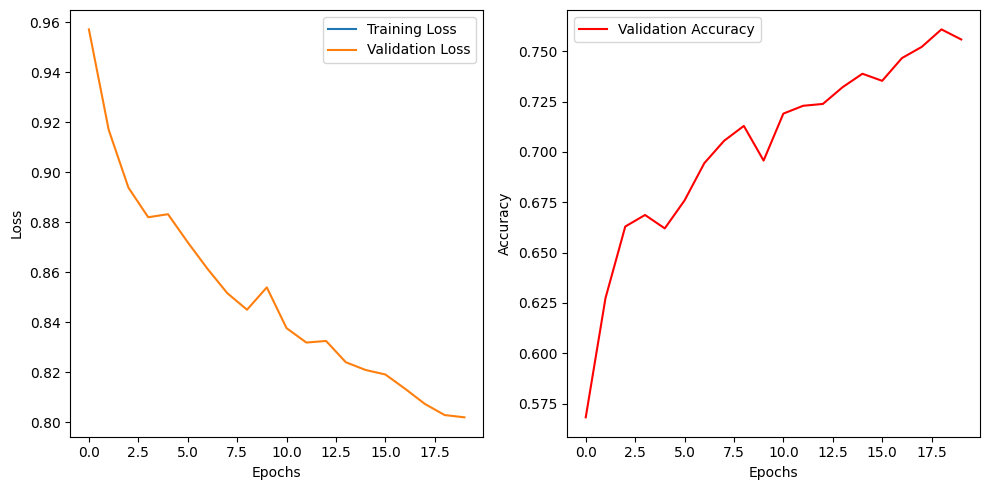

In [112]:
from matplotlib import pyplot as plt

# Графики обучения
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Training Loss')
plt.plot(validation_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(validation_accuracy_values, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [113]:
import torch
import random


# устанавливаем seed, чтобы результаты не изменялись при не изменение чего-либо
torch.manual_seed(666)
random.seed(666)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_model = NoMaskModel()
test_model = test_model.to(DEVICE)
test_model.load_state_dict(torch.load("models/model.pt"))
test_dataset = ImageToNumDataset("data/test_images", transform=transform)

In [114]:
import csv
from IPython.display import clear_output

test_model.eval()
len_dataset = len(test_dataset)
with open("answer.csv", "w") as file:
    writer = csv.writer(file, delimiter=",")
    writer.writerow(["id", "target_feature"])
    for index, image in enumerate(test_dataset):
        with torch.no_grad():
            pred_y = test_model(image.unsqueeze(0))
        answer = max(((n, i) for i, n in enumerate(pred_y[0])), key=lambda x: x[0])[1]
        writer.writerow([index, answer])
        if index % 10 == 0 or index % 10 == 9:
            print(f"{(index / len_dataset) * 100:.2f}%")
print("100%")

0.00%
0.13%
0.14%
0.27%
0.29%
0.42%
0.43%
0.56%
0.58%
0.71%
0.72%
0.85%
0.87%
1.00%
1.01%
1.14%
1.16%
1.29%
1.30%
1.43%
1.45%
1.58%
1.59%
1.72%
1.73%
1.86%
1.88%
2.01%
2.02%
2.15%
2.17%
2.30%
2.31%
2.44%
2.46%
2.59%
2.60%
2.73%
2.75%
2.88%
2.89%
3.02%
3.03%
3.16%
3.18%
3.31%
3.32%
3.45%
3.47%
3.60%
3.61%
3.74%
3.76%
3.89%
3.90%
4.03%
4.05%
4.18%
4.19%
4.32%
4.34%
4.47%
4.48%
4.61%
4.62%
4.75%
4.77%
4.90%
4.91%
5.04%
5.06%
5.19%
5.20%
5.33%
5.35%
5.48%
5.49%
5.62%
5.64%
5.77%
5.78%
5.91%
5.92%
6.05%
6.07%
6.20%
6.21%
6.34%
6.36%
6.49%
6.50%
6.63%
6.65%
6.78%
6.79%
6.92%
6.94%
7.07%
7.08%
7.21%
7.23%
7.36%
7.37%
7.50%
7.51%
7.64%
7.66%
7.79%
7.80%
7.93%
7.95%
8.08%
8.09%
8.22%
8.24%
8.37%
8.38%
8.51%
8.53%
8.66%
8.67%
8.80%
8.82%
8.95%
8.96%
9.09%
9.10%
9.23%
9.25%
9.38%
9.39%
9.52%
9.54%
9.67%
9.68%
9.81%
9.83%
9.96%
9.97%
10.10%
10.12%
10.25%
10.26%
10.39%
10.40%
10.53%
10.55%
10.68%
10.69%
10.82%
10.84%
10.97%
10.98%
11.11%
11.13%
11.26%
11.27%
11.40%
11.42%
11.55%
11.56%
11.69%
11.71